# SOIL FERTILITY CLASSIFICATION USING KNN MODEL

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load or Generate Soil Fertility Dataset

We'll generate a synthetic dataset for soil fertility classification. In a real-world scenario, you would load your actual data here.

In [95]:

def generate_synthetic_data(n_samples=50000):
    """
    Generate high-quality synthetic soil data with balanced and realistic fertility classes.
    
    This function simulates five soil parameters:
      - Nitrogen (ppm)
      - Phosphorus (ppm)
      - Potassium (ppm)
      - Electrical Conductivity, EC (dS/m)
      - Iron (ppm)
    
    A composite fertility score is computed and used to assign:
      - 'High' fertility if score >= 1.05
      - 'Low' fertility if score < 0.95
      - Otherwise, 'Medium'
    
    The multivariate generation for Nitrogen, Phosphorus, and Potassium incorporates realistic correlations.
    """
    np.random.seed(42)  # For reproducibility
    
    # Mean vector and covariance matrix for N, P, K
    mu = [150, 30, 200]  # Expected means for Nitrogen, Phosphorus, Potassium
    cov = [[2500, 150, 1400],   # Variance of N = 50^2, some covariance between N and P, N and K
           [150, 100, 210],     # Variance of P = 10^2
           [1400, 210, 4900]]   # Variance of K = 70^2

    # Generate Nitrogen, Phosphorus, Potassium jointly
    npk = np.random.multivariate_normal(mu, cov, n_samples)
    nitrogen = np.clip(npk[:, 0], 0, None)  # ensure non-negative values
    phosphorus = np.clip(npk[:, 1], 0, None)
    potassium = np.clip(npk[:, 2], 0, None)
    
    # Generate EC and Iron independently
    ec = np.random.normal(loc=0.8, scale=0.15, size=n_samples)
    iron = np.random.normal(loc=4.5, scale=1.0, size=n_samples)
    
    # Add measurement noise to imitate real-world variability
    nitrogen += np.random.uniform(-5, 5, size=n_samples)
    phosphorus += np.random.uniform(-2, 2, size=n_samples)
    potassium += np.random.uniform(-10, 10, size=n_samples)
    ec += np.random.uniform(-0.05, 0.05, size=n_samples)
    iron += np.random.uniform(-0.2, 0.2, size=n_samples)
    
    # Build the DataFrame
    data = pd.DataFrame({
        'Nitrogen': nitrogen,
        'Phosphorus': phosphorus,
        'Potassium': potassium,
        'EC': ec,
        'Iron': iron
    })
    
    # Compute a composite score using weighted ratios relative to expected means
    # The weights are chosen such that the average expected score is about 1.0.
    score = (
        0.3 * (data['Nitrogen'] / 150) +
        0.2 * (data['Phosphorus'] / 30) +
        0.3 * (data['Potassium'] / 200) +
        0.1 * (data['Iron'] / 4.5) +
        0.1 * (1 - np.abs(data['EC'] - 0.8) / 0.3)
    )
    
    # Assign Fertility Class based on the computed score
    # These thresholds can be adjusted to fine-tune class balance
    conditions = [
        score >= 1.05,      # High fertility if the composite score is significantly above average
        score < 0.95        # Low fertility if the composite score is below average
    ]
    choices = ['High', 'Low']
    data['FertilityClass'] = np.select(conditions, choices, default='Medium')
    
    # Shuffle the dataset to remove any ordering bias
    data = data.sample(frac=1).reset_index(drop=True)
    
    return data

# Attempt to load an existing CSV file; if not found, generate synthetic data.
try:
    print("Attempting to load soil fertility data from CSV...")
    soil_data = pd.read_csv('soil_fertility_data.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("No data file found. Generating synthetic data...")
    soil_data = generate_synthetic_data(50000)  # Increase sample size to 50,000
    print("Synthetic data generated!")

# Preview the first few rows of the dataset
print("\nPreview of the dataset:")
print(soil_data.head())

Attempting to load soil fertility data from CSV...
No data file found. Generating synthetic data...
Synthetic data generated!

Preview of the dataset:
     Nitrogen  Phosphorus   Potassium        EC      Iron FertilityClass
0  135.642225   19.624467  123.539426  0.662312  6.249476            Low
1  190.527622   37.265686  352.202843  0.996287  5.981644           High
2  107.003587   20.170923  173.944183  0.605490  3.436919            Low
3  123.292626   21.962009  266.392494  0.737365  3.884768         Medium
4  193.255123   32.087221  202.140862  0.858182  4.475841           High


In [96]:
print(soil_data.tail())
print(soil_data.describe())

         Nitrogen  Phosphorus   Potassium        EC      Iron FertilityClass
49995  126.392832   48.927303  322.379758  0.751087  4.152414           High
49996  116.242332   18.028499  112.185763  0.895413  4.649172            Low
49997  177.993445   33.956163  184.216248  0.629319  3.673166         Medium
49998  169.885034   27.007711  145.254602  0.686936  4.230466            Low
49999  167.889547   29.248544  184.510260  0.871345  4.990683         Medium
           Nitrogen    Phosphorus     Potassium            EC          Iron
count  50000.000000  50000.000000  50000.000000  50000.000000  50000.000000
mean     150.106880     29.947616    200.171368      0.799781      4.497868
std       49.925399     10.044264     70.288133      0.152354      1.006390
min       -4.617447     -1.946584     -9.961996      0.180692      0.188925
25%      116.143660     23.167462    152.718002      0.697145      3.819093
50%      149.934640     29.886105    200.231093      0.799578      4.502856
75%   

## 3. Exploratory Data Analysis (EDA)

In [97]:
# Check basic information about the dataset
print("Dataset shape:", soil_data.shape)
print("\nBasic statistics:")
soil_data.describe()

Dataset shape: (50000, 6)

Basic statistics:


,Nitrogen,Phosphorus,Potassium,EC,Iron
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,150.106880,29.947616,200.171368,0.799781,4.497868
std,49.925399,10.044264,70.288133,0.152354,1.006390
min,-4.617447,-1.946584,-9.961996,0.180692,0.188925
25%,116.143660,23.167462,152.718002,0.697145,3.819093
50%,149.934640,29.886105,200.231093,0.799578,4.502856
75%,183.977724,36.757028,247.488065,0.903267,5.178751
max,382.013927,72.087703,523.490893,1.395547,8.470303



Distribution of Fertility Classes:
FertilityClass
Low       24061
High      16588
Medium     9351
Name: count, dtype: int64


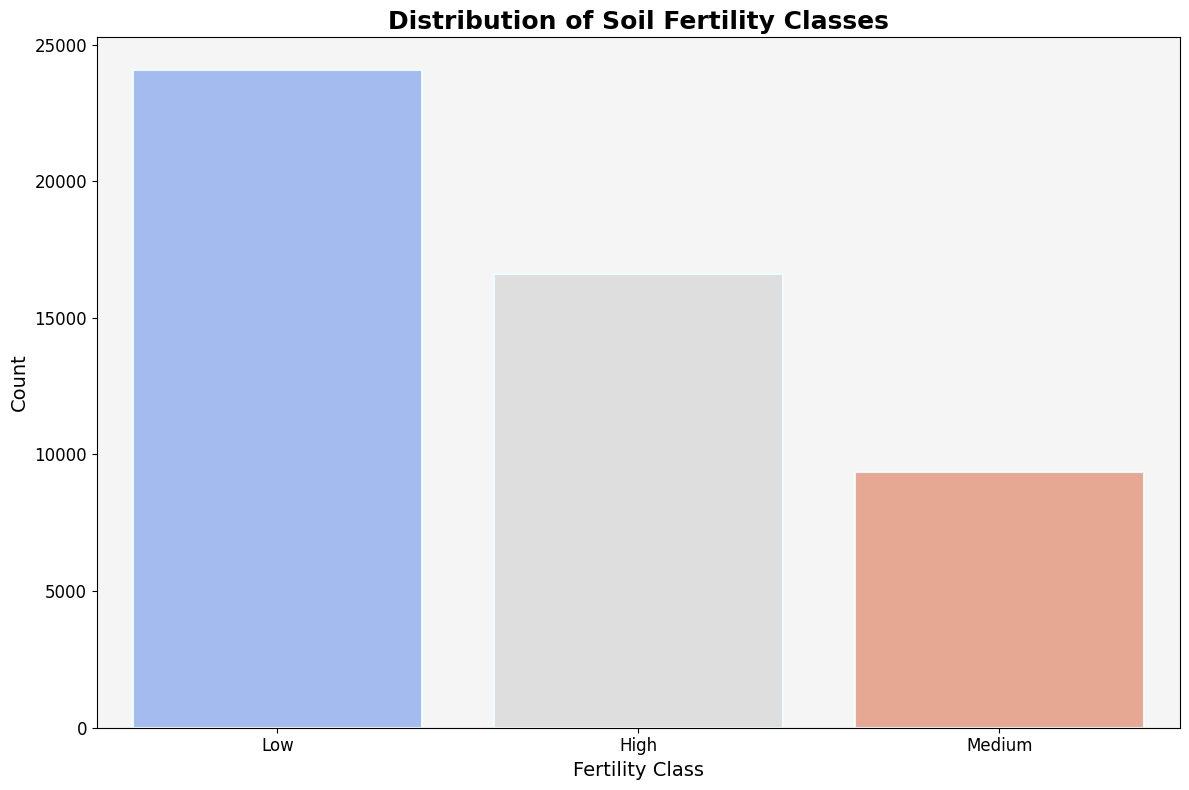

In [98]:
# Analyze the distribution of Fertility Classes
class_dist = soil_data['FertilityClass'].value_counts()
print("\nDistribution of Fertility Classes:")
print(class_dist)

# Visualize the distribution with modern design elements
plt.figure(figsize=(12, 8))

sns.countplot(
    x='FertilityClass', 
    data=soil_data, 
    palette='coolwarm',    # Modern and visually appealing palette
    edgecolor='azure',     # Defines sharp edges for visual clarity
    hue='FertilityClass',  # Adds color differentiation for classes
    linewidth=1.5,         # Enhances edge visibility
    alpha=0.9              # Adjusts transparency for better aesthetics
)

# Add a gradient background for visual enhancement
plt.gca().set_facecolor('#f5f5f5')

# Improve the layout and readability of the plot
plt.title("Distribution of Soil Fertility Classes", fontsize=18, fontweight='bold')
plt.ylabel("Count", fontsize=14)
plt.xlabel("Fertility Class", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout for neat presentation
plt.tight_layout()

# Display the plot
plt.show()

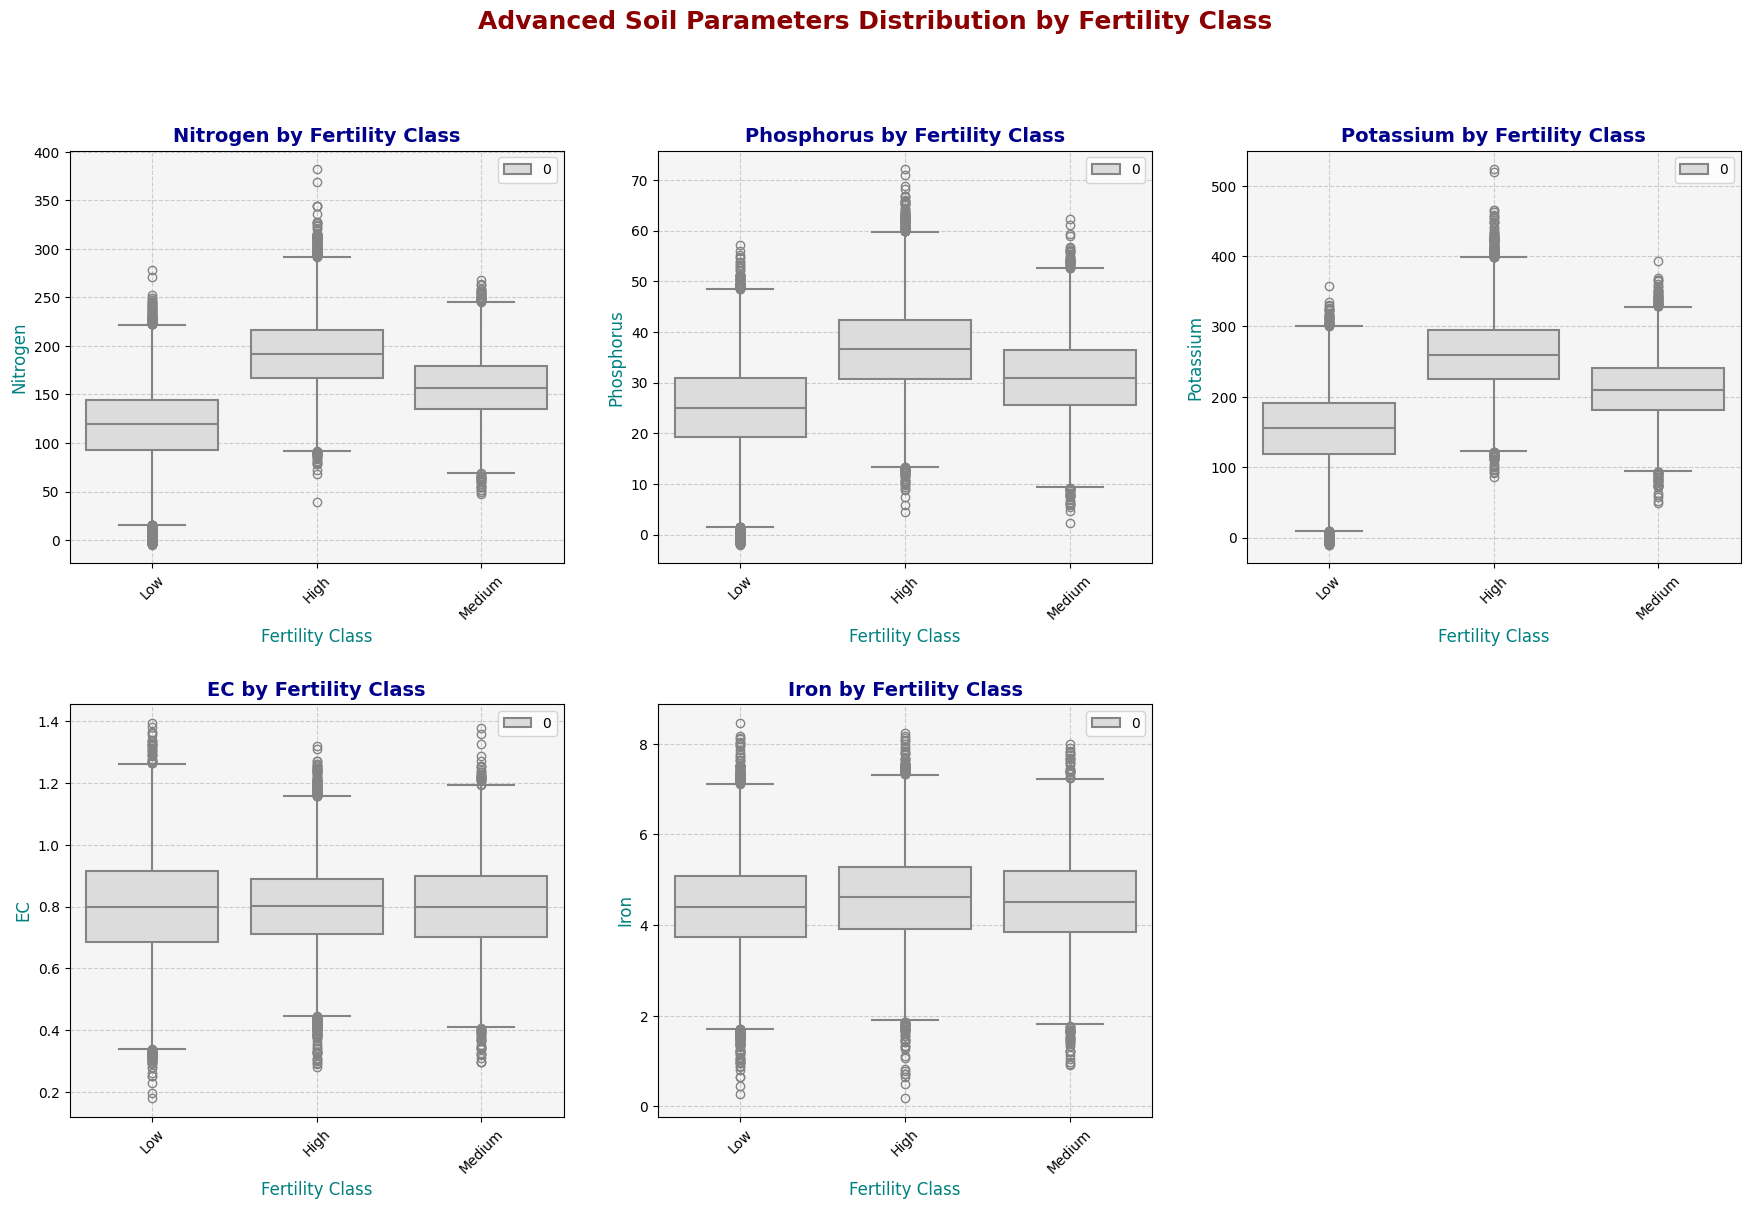

In [99]:
# Updated visualization for Soil Parameters vs Fertility Class
plt.figure(figsize=(18, 12))  # Adjusted size for better presentation

# List of features from the dataset
features = ['Nitrogen', 'Phosphorus', 'Potassium', 'EC', 'Iron']


for i, feature in enumerate(features, 1):
    ax = plt.subplot(2, 3, i)  # Create subplots in a 2x3 grid
    sns.boxplot(
        x='FertilityClass', 
        y=feature, 
        data=soil_data, 
        palette='coolwarm',   # Modern color palette for aesthetics
        hue=0,                # No hue for this plot
        linewidth=1.5,        # Sharp borders for better visibility
        dodge=False           # Ensure consistent box positions
    )
    
    # Add dynamic axis labels and titles
    ax.set_title(f"{feature} by Fertility Class", fontsize=14, fontweight='bold', color='darkblue')
    ax.set_xlabel("Fertility Class", fontsize=12, color='teal')
    ax.set_ylabel(feature, fontsize=12, color='teal')
    
    # Enhance subplot appearance
    ax.set_facecolor('#f5f5f5')  # Soft background for clarity
    ax.grid(True, linestyle='--', alpha=0.6)  # Add gridlines for better data interpretation
    
    # Rotate x-tick labels if needed
    ax.tick_params(axis='x', rotation=45, labelsize=10)

# Add a main title for the entire visualization
plt.suptitle(
    "Advanced Soil Parameters Distribution by Fertility Class",
    fontsize=18, fontweight='bold', color='darkred', y=1.02
)

# Adjust layout to ensure neat presentation
plt.tight_layout(pad=2.5)
plt.show()

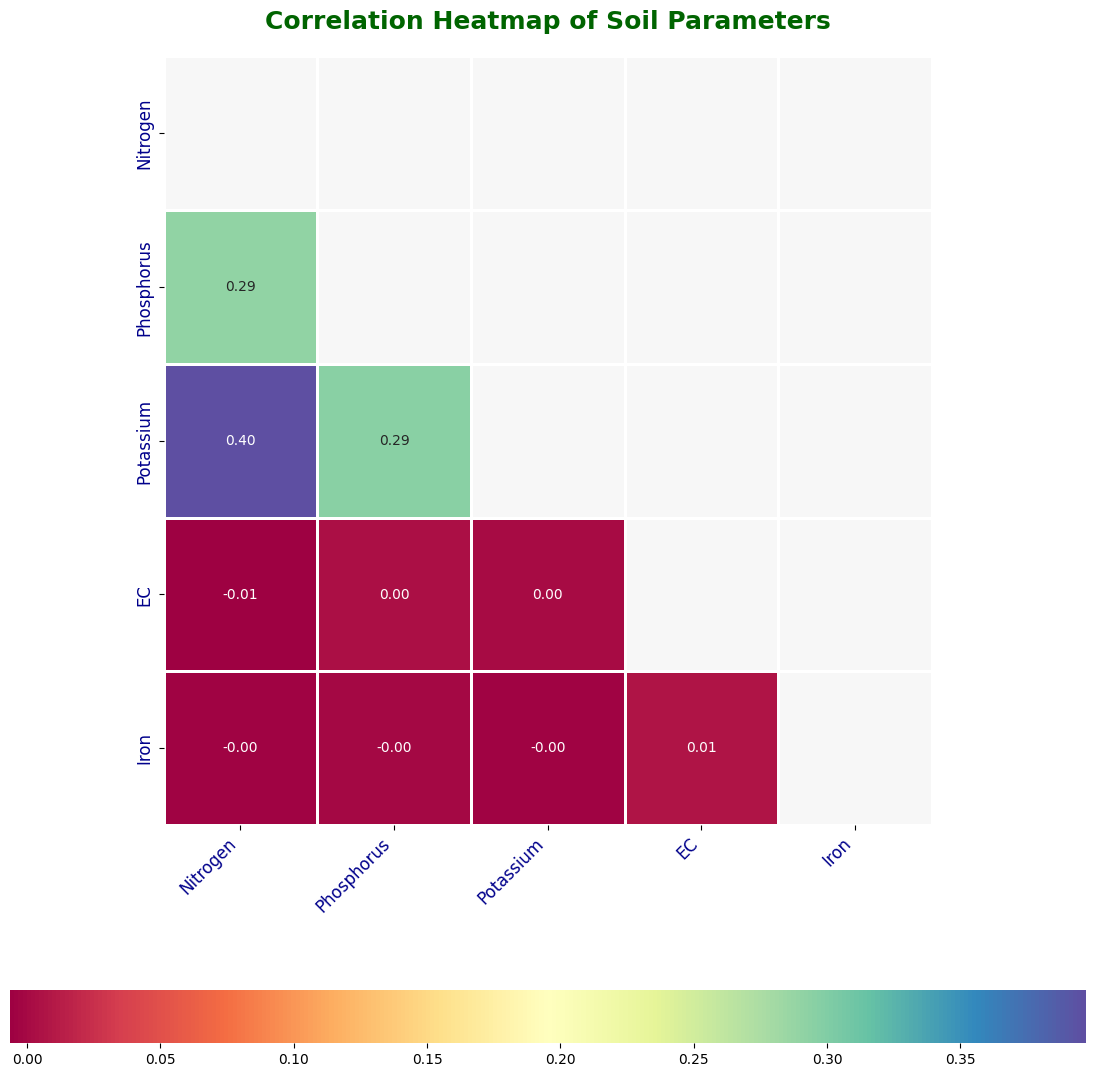

In [100]:
# Advanced Correlation Heatmap
plt.figure(figsize=(14, 12))  # Larger figure for better readability

# Compute the correlation matrix
correlation = soil_data.drop('FertilityClass', axis=1).corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation))

# Plot the heatmap
sns.heatmap(
    correlation, 
    annot=True,        # Display correlation values
    mask=mask,         # Mask upper triangle
    cmap='Spectral',   # Modern colormap for enhanced differentiation
    fmt=".2f",         # Format correlation values to 2 decimal places
    linewidths=1,      # Define clearer gridlines
    linecolor='white', # Ensure gridlines are clearly visible
    square=True,       # Keep cells as perfect squares
    cbar_kws={'shrink': 0.8, 'orientation': 'horizontal'}  # Modernize colorbar
)

# Enhance the title and layout
plt.title(
    "Correlation Heatmap of Soil Parameters",
    fontsize=18, fontweight='bold', color='darkgreen', pad=20
)
plt.xticks(fontsize=12, rotation=45, ha='right', color='darkblue')  # Rotated for readability
plt.yticks(fontsize=12, color='darkblue')

# Highlight main layout improvements
plt.tight_layout(pad=2)
plt.gca().set_facecolor('#f7f7f7')  # Light background for clarity

plt.show()

## 4. Data Preprocessing

Before we build our KNN model, we'll need to preprocess our data, including:
- Separating features and target variable
- Encoding categorical targets
- Splitting the dataset into training and testing sets
- Feature scaling

In [102]:
# Create the feature matrix (X) and the target vector (y)
X = soil_data.drop('FertilityClass', axis=1)
y = soil_data['FertilityClass']

# Encode the target classes (convert text labels to integers)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Map the encoded values to their original labels for reference
class_mapping = dict(zip(range(len(le.classes_)), le.classes_))
print("Class mapping:", class_mapping)

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Apply feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")
print(f"Samples in each class (training): {pd.Series(y_train).value_counts().sort_index()}")

Class mapping: {0: 'High', 1: 'Low', 2: 'Medium'}
Training set shape: (40000, 5)
Testing set shape: (10000, 5)
Samples in each class (training): 0    13270
1    19249
2     7481
Name: count, dtype: int64


## 5. Model Training and Evaluation

We'll train a KNN model for soil fertility classification, find the optimal number of neighbors using cross-validation, and evaluate the model's performance.

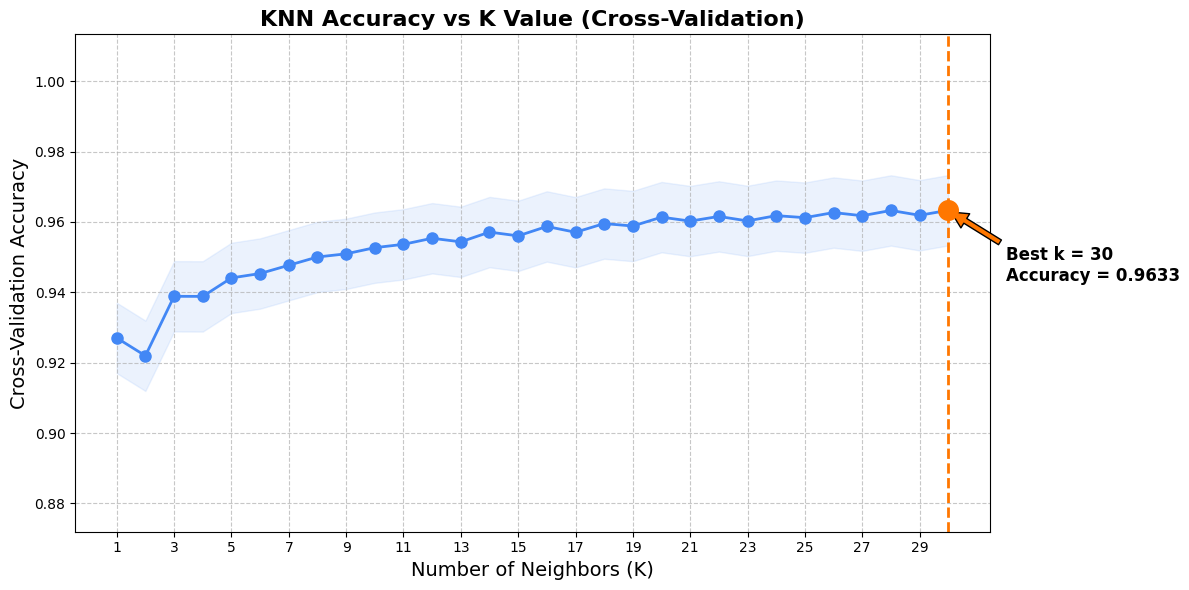

Best K value: 30 with accuracy: 0.9633


In [103]:
# Find the optimal value of K using cross-validation
k_range = range(1, 31)
cv_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plot the cross-validation results
plt.figure(figsize=(12, 6))
plt.plot(k_range, cv_scores, marker='o', markersize=8, color='#4287f5', linewidth=2)
plt.fill_between(k_range, np.array(cv_scores) - 0.01, np.array(cv_scores) + 0.01, alpha=0.1, color='#4287f5')

plt.title('KNN Accuracy vs K Value (Cross-Validation)', fontsize=16, fontweight='bold')
plt.xlabel('Number of Neighbors (K)', fontsize=14)
plt.ylabel('Cross-Validation Accuracy', fontsize=14)
plt.xticks(k_range[::2])
plt.grid(True, linestyle='--', alpha=0.7)

# Find and highlight the best k value
best_k = k_range[np.argmax(cv_scores)]
best_score = max(cv_scores)
plt.axvline(x=best_k, color='#ff7700', linestyle='--', linewidth=2)
plt.scatter(best_k, best_score, color='#ff7700', s=200, zorder=5)

plt.annotate(f'Best k = {best_k}\nAccuracy = {best_score:.4f}',
             (best_k, best_score),
             xytext=(best_k+2, best_score-0.02),
             arrowprops=dict(facecolor='#ff7700', shrink=0.05),
             fontsize=12, fontweight='bold')

plt.ylim(min(cv_scores)-0.05, max(cv_scores)+0.05)
plt.tight_layout()
plt.show()

print(f"Best K value: {best_k} with accuracy: {best_score:.4f}")

In [104]:
# Train the KNN model with the best K value
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = best_knn.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[class_mapping[i] for i in sorted(class_mapping.keys())]))

Test Accuracy: 0.9643

Classification Report:
              precision    recall  f1-score   support

        High       0.97      0.98      0.98      3318
         Low       0.98      0.98      0.98      4812
      Medium       0.91      0.90      0.90      1870

    accuracy                           0.96     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.96      0.96      0.96     10000



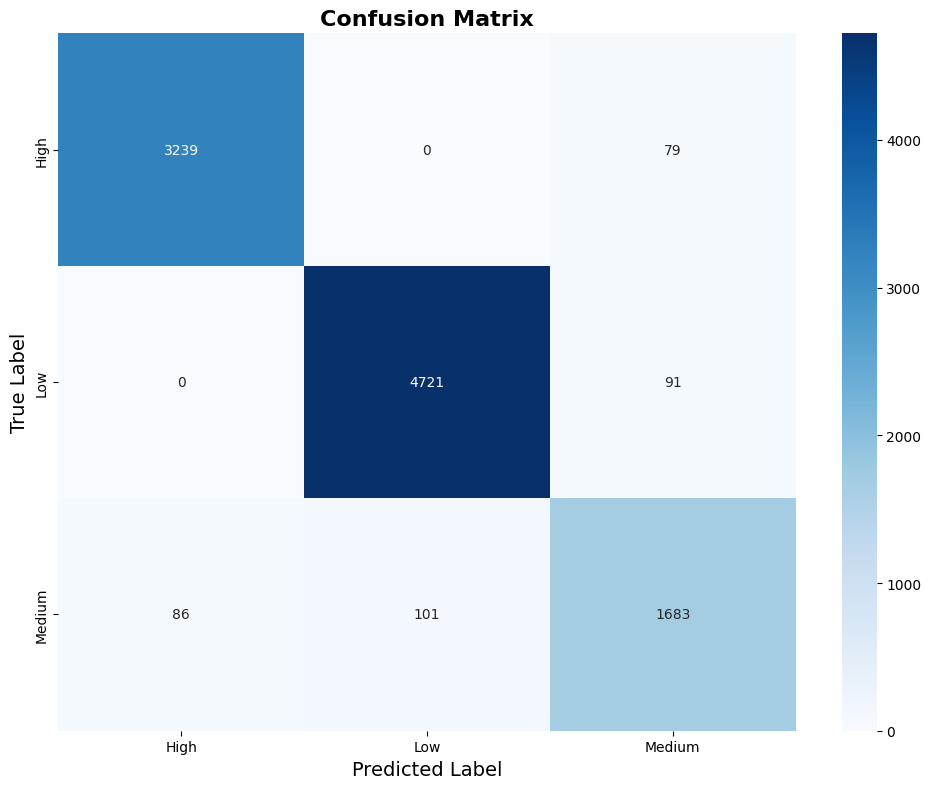

In [105]:
# Generate and visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=[class_mapping[i] for i in sorted(class_mapping.keys())],
    yticklabels=[class_mapping[i] for i in sorted(class_mapping.keys())]
)

plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Working with N, P, K, EC, Fe Dataset

Now we'll implement the KNN model for a dataset with the specific parameters: N (Nitrogen), P (Phosphorus), K (Potassium), EC (Electrical Conductivity), and Fe (Iron).

In [107]:
# Create a function to generate or load a dataset with N, P, K, EC, Fe parameters
def create_npk_ec_fe_dataset(n_samples=400):
    np.random.seed(42)
    
    # Generate features with realistic ranges for soil parameters
    nitrogen = np.random.normal(loc=140, scale=45, size=n_samples)  # ppm
    phosphorus = np.random.normal(loc=25, scale=12, size=n_samples)  # ppm
    potassium = np.random.normal(loc=180, scale=55, size=n_samples)  # ppm
    ec = np.random.normal(loc=1.2, scale=0.5, size=n_samples)  # dS/m (deciSiemens per meter)
    iron = np.random.normal(loc=12, scale=5, size=n_samples)  # ppm
    
    # Create DataFrame
    data = pd.DataFrame({
        'N': nitrogen,
        'P': phosphorus,
        'K': potassium,
        'EC': ec,
        'Fe': iron
    })
    
    # Define fertility classes based on agronomic thresholds
    # These thresholds are simplified for demonstration
    fertility_class = []
    
    for i in range(n_samples):
        n, p, k = nitrogen[i], phosphorus[i], potassium[i]
        ec_val = ec[i]
        fe_val = iron[i]
        
        # High fertility conditions
        if (n > 170 and p > 30 and k > 220 and 0.8 < ec_val < 1.6 and 10 < fe_val < 20):
            fertility_class.append('High')
        # Low fertility conditions
        elif (n < 100 or p < 15 or k < 140 or ec_val > 2.0 or ec_val < 0.5 or fe_val < 5 or fe_val > 25):
            fertility_class.append('Low')
        # Medium fertility (anything between high and low)
        else:
            fertility_class.append('Medium')
    
    data['FertilityClass'] = fertility_class
    return data

# Try to load a CSV with this data or create synthetic data
try:
    print("Attempting to load N,P,K,EC,Fe soil dataset...")
    npk_data = pd.read_csv('npk_ec_fe_soil_data.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("No N,P,K,EC,Fe dataset found. Generating synthetic data...")
    npk_data = create_npk_ec_fe_dataset(400)
    print("Synthetic N,P,K,EC,Fe data generated!")

# Display the first few rows
npk_data.head()

Attempting to load N,P,K,EC,Fe soil dataset...
No N,P,K,EC,Fe dataset found. Generating synthetic data...
Synthetic N,P,K,EC,Fe data generated!


,N,P,K,EC,Fe,FertilityClass
0,162.352137,5.866868,231.605609,1.262612,11.085518,Low
1,133.778106,17.807500,151.617540,0.985297,18.874382,Medium
2,169.145984,25.062924,185.286643,1.261149,8.770179,Medium
3,208.536344,25.563767,154.574859,1.471649,8.004040,Medium
4,129.463098,19.599214,156.102707,1.224430,9.586282,Medium


Dataset shape: (400, 6)

Class distribution:
FertilityClass
Low       236
Medium    162
High        2
Name: count, dtype: int64


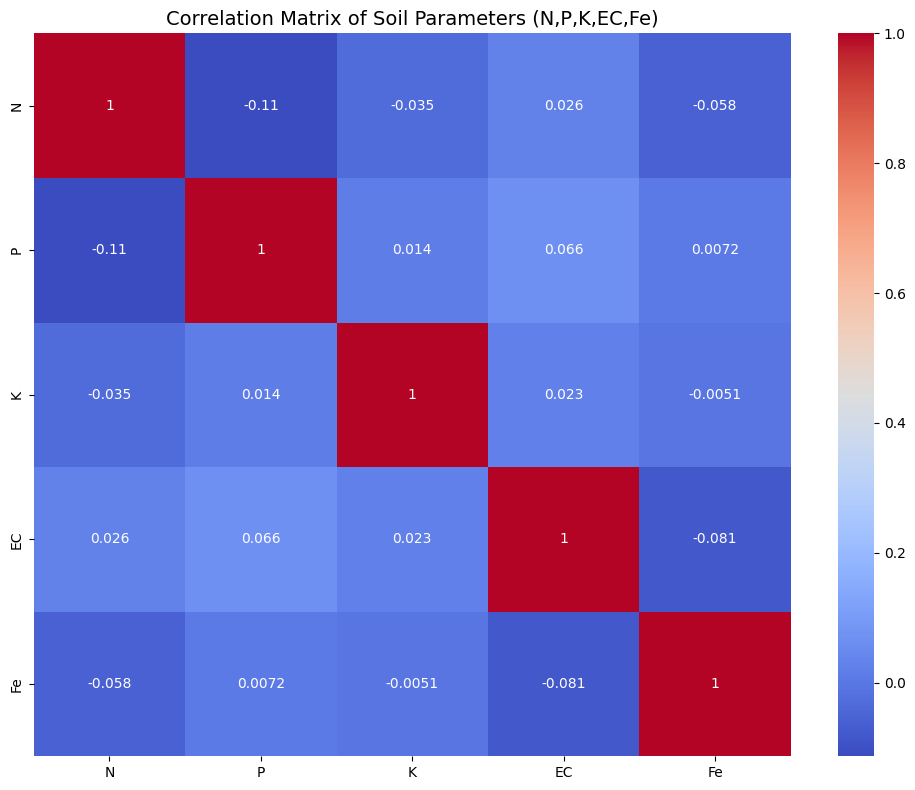

/tmp/ipykernel_55143/3560530363.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='FertilityClass', y=feature, data=npk_data, palette='viridis')
/tmp/ipykernel_55143/3560530363.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='FertilityClass', y=feature, data=npk_data, palette='viridis')
/tmp/ipykernel_55143/3560530363.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='FertilityClass', y=feature, data=npk_data, palette='viridis')
/tmp/ipykernel_55143/3560530363.py:18: FutureWarning: 

Passing `palette` without assigning `hue`

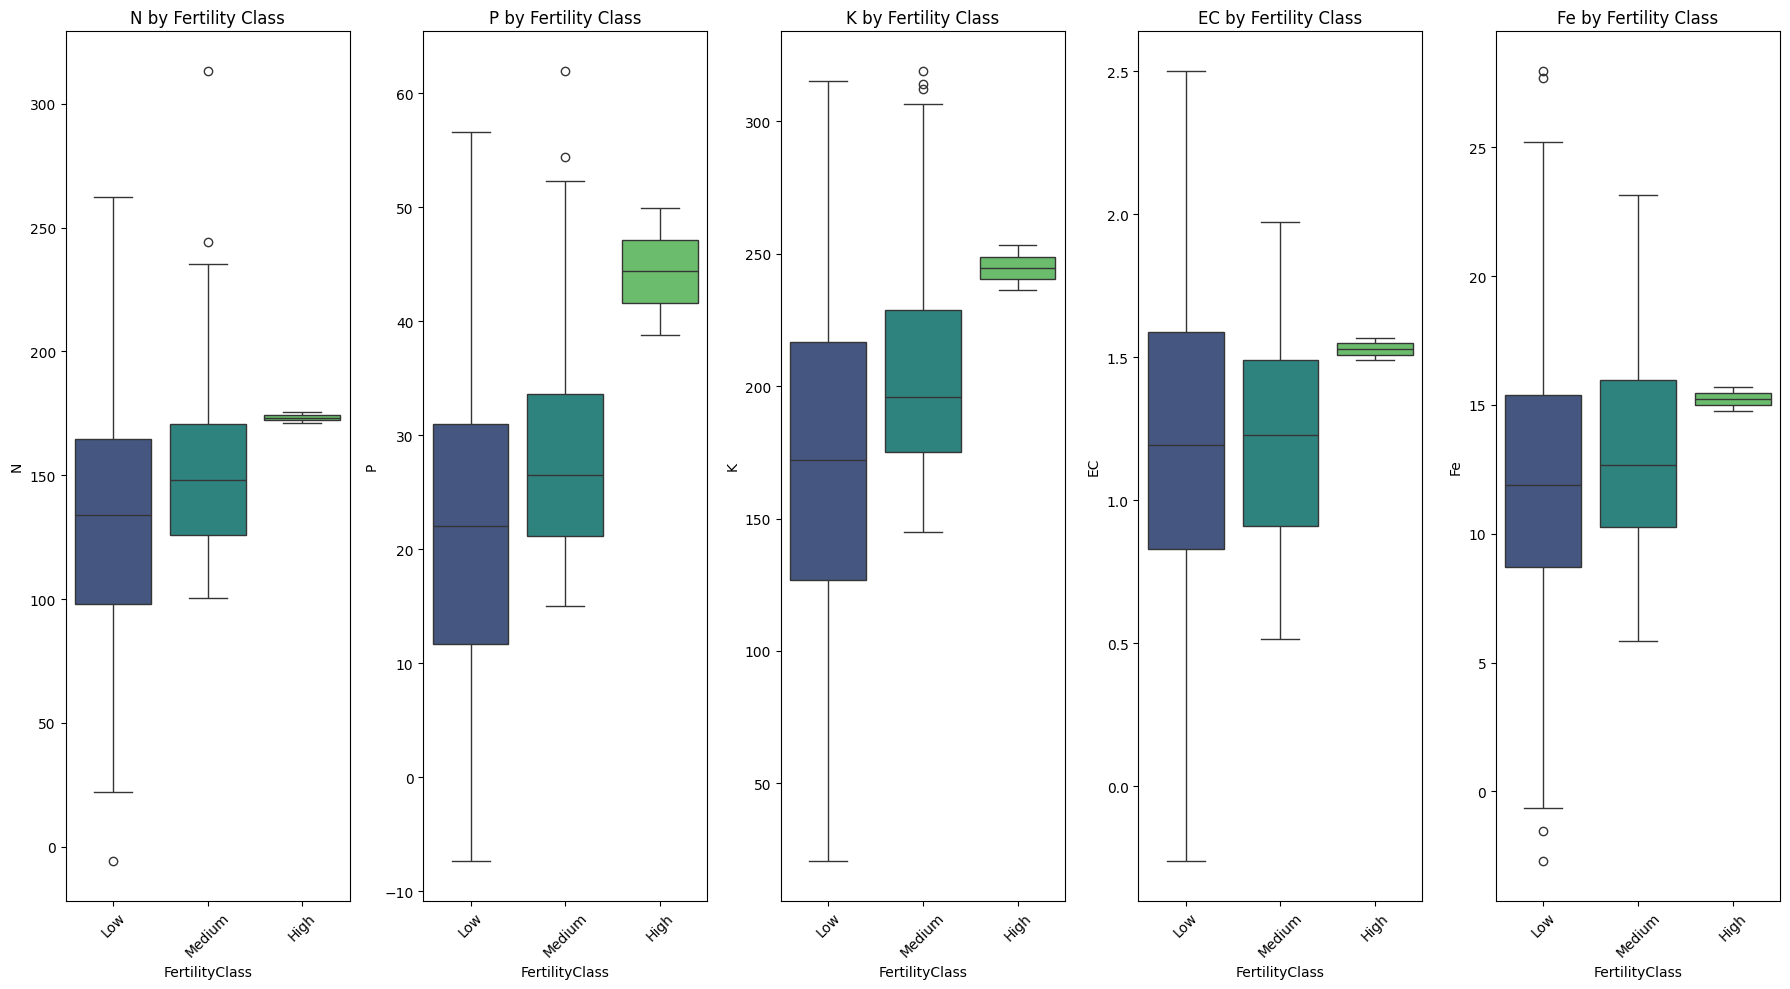

In [108]:
# Quick EDA for the NPK-EC-Fe dataset
print("Dataset shape:", npk_data.shape)
print("\nClass distribution:")
print(npk_data['FertilityClass'].value_counts())

# Create a correlation heatmap
plt.figure(figsize=(10, 8))
correlation = npk_data.drop('FertilityClass', axis=1).corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Soil Parameters (N,P,K,EC,Fe)', fontsize=14)
plt.tight_layout()
plt.show()

# Show boxplots for each feature by fertility class
plt.figure(figsize=(18, 10))
for i, feature in enumerate(['N', 'P', 'K', 'EC', 'Fe']):
    plt.subplot(1, 5, i+1)
    sns.boxplot(x='FertilityClass', y=feature, data=npk_data, palette='viridis')
    plt.title(f'{feature} by Fertility Class')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [109]:
# Preprocess the NPK-EC-Fe dataset
X_npk = npk_data.drop('FertilityClass', axis=1)
y_npk = npk_data['FertilityClass']

# Encode target variable
le_npk = LabelEncoder()
y_npk_encoded = le_npk.fit_transform(y_npk)
npk_class_mapping = dict(zip(range(len(le_npk.classes_)), le_npk.classes_))
print("Class mapping:", npk_class_mapping)

# Split the dataset
X_npk_train, X_npk_test, y_npk_train, y_npk_test = train_test_split(
    X_npk, y_npk_encoded, test_size=0.2, random_state=42, stratify=y_npk_encoded
)

# Scale features
npk_scaler = StandardScaler()
X_npk_train_scaled = npk_scaler.fit_transform(X_npk_train)
X_npk_test_scaled = npk_scaler.transform(X_npk_test)

print(f"Training set shape: {X_npk_train_scaled.shape}")
print(f"Testing set shape: {X_npk_test_scaled.shape}")

Class mapping: {0: 'High', 1: 'Low', 2: 'Medium'}
Training set shape: (320, 5)
Testing set shape: (80, 5)


/workspaces/SDP_Agri_Swastha/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/workspaces/SDP_Agri_Swastha/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/workspaces/SDP_Agri_Swastha/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/workspaces/SDP_Agri_Swastha/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/workspaces/SDP_Agri_Swastha/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated clas

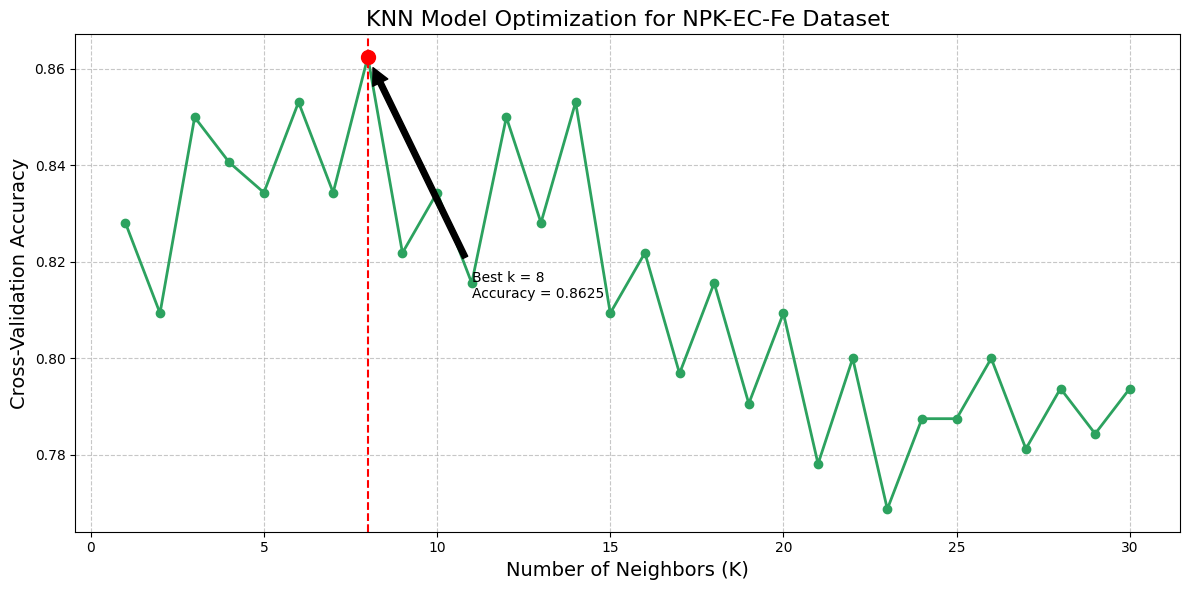

Best K value for NPK-EC-Fe dataset: 8 with accuracy: 0.8625


In [110]:
# Find the optimal K value for NPK-EC-Fe dataset
k_range = range(1, 31)
npk_cv_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_npk_train_scaled, y_npk_train, cv=5, scoring='accuracy')
    npk_cv_scores.append(scores.mean())

# Plot the cross-validation results
plt.figure(figsize=(12, 6))
plt.plot(k_range, npk_cv_scores, marker='o', color='#2ca25f', linewidth=2)

# Find and highlight the best k value
best_npk_k = k_range[np.argmax(npk_cv_scores)]
best_npk_score = max(npk_cv_scores)

plt.axvline(x=best_npk_k, color='red', linestyle='--')
plt.scatter(best_npk_k, best_npk_score, color='red', s=100, zorder=5)

plt.title('KNN Model Optimization for NPK-EC-Fe Dataset', fontsize=16)
plt.xlabel('Number of Neighbors (K)', fontsize=14)
plt.ylabel('Cross-Validation Accuracy', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.annotate(f'Best k = {best_npk_k}\nAccuracy = {best_npk_score:.4f}', 
             xy=(best_npk_k, best_npk_score), 
             xytext=(best_npk_k+3, best_npk_score-0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()

print(f"Best K value for NPK-EC-Fe dataset: {best_npk_k} with accuracy: {best_npk_score:.4f}")

Test Accuracy: 0.8375

Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00         1
         Low       0.93      0.81      0.86        47
      Medium       0.74      0.91      0.82        32

    accuracy                           0.84        80
   macro avg       0.56      0.57      0.56        80
weighted avg       0.84      0.84      0.83        80



/workspaces/SDP_Agri_Swastha/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/workspaces/SDP_Agri_Swastha/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/workspaces/SDP_Agri_Swastha/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

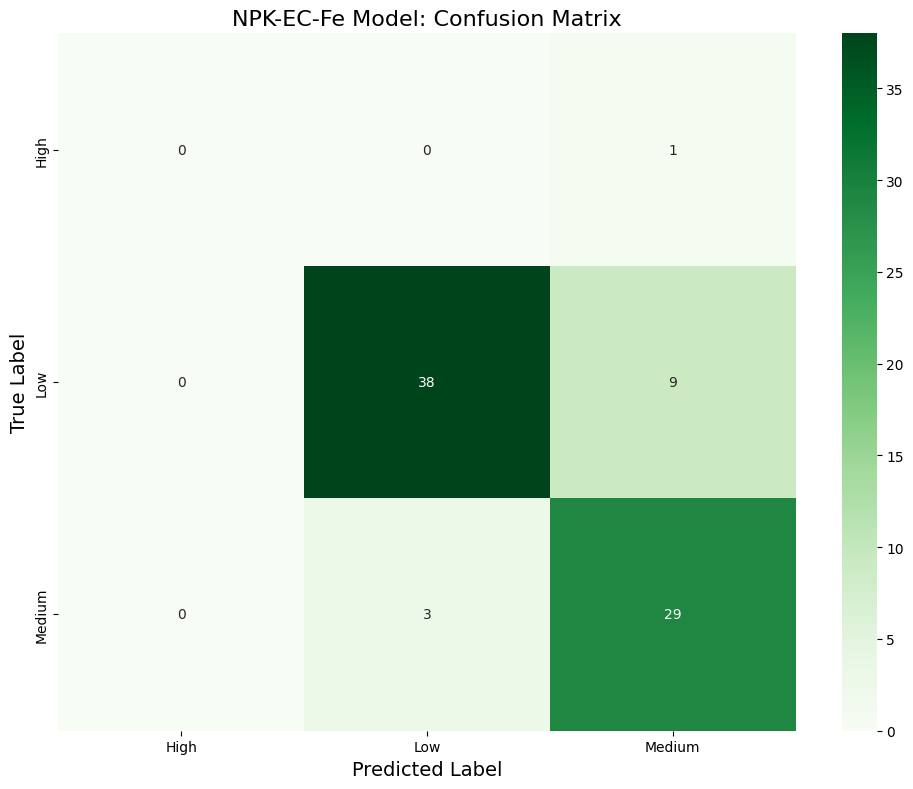

In [111]:
# Train the KNN model with the optimal K value
best_npk_knn = KNeighborsClassifier(n_neighbors=best_npk_k)
best_npk_knn.fit(X_npk_train_scaled, y_npk_train)

# Make predictions on the test set
y_npk_pred = best_npk_knn.predict(X_npk_test_scaled)

# Calculate accuracy
npk_accuracy = accuracy_score(y_npk_test, y_npk_pred)
print(f"Test Accuracy: {npk_accuracy:.4f}")

# Generate classification report
target_names = [npk_class_mapping[i] for i in sorted(npk_class_mapping.keys())]
print("\nClassification Report:")
print(classification_report(y_npk_test, y_npk_pred, target_names=target_names))

# Generate confusion matrix
cm_npk = confusion_matrix(y_npk_test, y_npk_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_npk, 
    annot=True, 
    fmt='d', 
    cmap='Greens',
    xticklabels=target_names,
    yticklabels=target_names
)

plt.title('NPK-EC-Fe Model: Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.show()